### Apply layer-parallel Torchbraid to simple MNIST problem (fashion or digits)
- See `start0_install_mpi_notebook.ipynb`, and `start1_simple_mpi_notebook.ipynb` for setting up MPI-compatible Jupyter installation
- Recommended to start ipython cluster for default notebook settings with (assumes 4 cores)

        $ ipcluster start --n=4 --engines=mpi --profile=mpi

  or

        $ ipcluster start --n=4 --engines=MPIEngineSetLauncher --profile=mpi
        
#### Layer-parallel runs most efficiently when the 

    (number of processors)*(coarsening factor) = k*(number of ResNet Layers)
    
where `k` is some integer. This experiment is designed to satisfy this with the default parameters and four processors.

In [1]:
# Connect to local ipython cluster.  Note, the ipcluster profile name must match the
# below named profile. Here, we use 'mpi', but you can name the cluster profile anything
from ipyparallel import Client, error
cluster = Client(profile='mpi')
print('profile:', cluster.profile)
print("IDs:", cluster.ids) 

profile: mpi
IDs: [0, 1, 2, 3]


In [2]:
%%px
# Must point to your Torchbraid location, used for location to download MNIST dataset
torchbraid_path = "/Users/jacobschroder/joint_repos/torchbraid/torchbraid_py3_10"

# If using Makefile Torchbraid install, must uncomment to update system path to Torchbraid 
#sys.path.append(torchbraid_path + "/src")

In [3]:
%%px
from __future__ import print_function

import statistics as stats
import sys
from timeit import default_timer as timer

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from mpi4py import MPI

import torchbraid
import torchbraid.utils

In [4]:
%%px
# Download the data
rank = MPI.COMM_WORLD.Get_rank()
if rank == 0:
  datasets.MNIST(torchbraid_path + '/examples/mnist/digit-data', download=True)
  datasets.FashionMNIST(torchbraid_path + '/examples/mnist/fashion-data', download=True)

In [5]:
%%px
# Network architecture is Open + ResNet + Close
# The StepLayer defines the ResNet (ODENet) 
class OpenFlatLayer(nn.Module):
  ''' 
  Opening layer has no parameters, replicates image number of channels times
  '''
  def __init__(self, channels):
    super(OpenFlatLayer, self).__init__()
    self.channels = channels

  def forward(self, x):
    s = len(x.shape) * [1]
    s[1] = self.channels
    x = x.repeat(s)
    return x

class CloseLayer(nn.Module):
  '''
  Dense closing classification layer
  '''
  def __init__(self, channels):
    super(CloseLayer, self).__init__()
    self.fc1 = nn.Linear(channels * 28 * 28, 32)
    self.fc2 = nn.Linear(32, 10)

  def forward(self, x):
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    return F.log_softmax(x, dim=1)

class StepLayer(nn.Module):
  '''
  ResNet composed of convolutional layers
  '''
  def __init__(self, channels):
    super(StepLayer, self).__init__()
    ker_width = 3
    self.conv1 = nn.Conv2d(channels, channels, ker_width, padding=1)
    self.conv2 = nn.Conv2d(channels, channels, ker_width, padding=1)

  def forward(self, x):
    return F.relu(self.conv2(F.relu(self.conv1(x))))

In [6]:
%%px
# Parallel network class, primarily builds a LayerParallel network object
# local_steps: number of ResNet layers per processor
# all other parameter definitions are in params['...'] block below 
class ParallelNet(nn.Module):
  def __init__(self, channels=12, local_steps=8, Tf=1.0, max_levels=1, bwd_max_iters=1, 
               fwd_max_iters=2, print_level=0, braid_print_level=0, cfactor=4, 
               fine_fcf=False, skip_downcycle=True, fmg=False, relax_only_cg=0,
               user_mpi_buf=False, gpu_direct_commu=False):
    super(ParallelNet, self).__init__()

    step_layer = lambda: StepLayer(channels)
    numprocs = MPI.COMM_WORLD.Get_size()
    
    self.parallel_nn = torchbraid.LayerParallel(MPI.COMM_WORLD, step_layer, local_steps*numprocs, Tf,
                                                max_fwd_levels=max_levels, max_bwd_levels=max_levels,
                                                max_iters=2, user_mpi_buf=user_mpi_buf,
                                                gpu_direct_commu=gpu_direct_commu)
    self.parallel_nn.setBwdMaxIters(bwd_max_iters)
    self.parallel_nn.setFwdMaxIters(fwd_max_iters)
    self.parallel_nn.setPrintLevel(print_level, True)
    self.parallel_nn.setPrintLevel(braid_print_level, False)
    self.parallel_nn.setCFactor(cfactor)
    self.parallel_nn.setSkipDowncycle(skip_downcycle)
    self.parallel_nn.setBwdRelaxOnlyCG(relax_only_cg)
    self.parallel_nn.setFwdRelaxOnlyCG(relax_only_cg)
    if fmg:
      self.parallel_nn.setFMG()
    
    self.parallel_nn.setNumRelax(1)  # FCF relaxation default on coarse levels
    if not fine_fcf:
      self.parallel_nn.setNumRelax(0, level=0)  # Set F-Relaxation only on the fine grid
    else:
      self.parallel_nn.setNumRelax(1, level=0)  # Set FCF-Relaxation on the fine grid

    # this object ensures that only the LayerParallel code runs on ranks!=0
    compose = self.compose = self.parallel_nn.comp_op()

    # by passing this through 'compose' (mean composition: e.g. OpenFlatLayer o channels)
    # on processors not equal to 0, these will be None (there are no parameters to train there)
    self.open_nn = compose(OpenFlatLayer, channels)
    self.close_nn = compose(CloseLayer, channels)

  def forward(self, x):
    # by passing this through 'o' (mean composition: e.g. self.open_nn o x)
    # this makes sure this is run on only processor 0

    x = self.compose(self.open_nn, x)
    x = self.parallel_nn(x)
    x = self.compose(self.close_nn, x)

    return x


In [7]:
%%px
# Train model for one epoch
# Return values: per batch losses and training times, model parameters updated in-place
def train(rank, params, model, train_loader, optimizer, epoch, compose, device):
  train_times = []
  losses = []
  model.train()
  criterion = nn.CrossEntropyLoss()
  total_time = 0.0
  for batch_idx, (data, target) in enumerate(train_loader):
    start_time = timer()
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = compose(criterion, output, target)
    loss.backward()
    stop_time = timer()
    optimizer.step()

    total_time += stop_time - start_time
    train_times.append(stop_time - start_time)
    losses.append(loss.item())
    if batch_idx % params['log_interval'] == 0:
      root_print(rank, 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tTime Per Batch {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
               100. * batch_idx / len(train_loader), loss.item(), total_time / (batch_idx + 1.0)))

  root_print(rank, 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tTime Per Batch {:.6f}'.format(
    epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
           100. * (batch_idx + 1) / len(train_loader), loss.item(), total_time / (batch_idx + 1.0)))
  return losses, train_times

In [8]:
%%px
# Evaluate model on validation data
# Return: number of correctly classified test items, total number of test items, loss on test data set
def test(rank, model, test_loader, compose, device):
  model.eval()
  test_loss = 0
  correct = 0
  criterion = nn.CrossEntropyLoss()
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      test_loss += compose(criterion, output, target).item()

      if rank == 0:
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)

  root_print(rank, '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
  return correct, len(test_loader.dataset), test_loss

In [9]:
%%px
# Parallel printing helper function
def root_print(rank, s):
  if rank == 0:
    print(s)

# Compute number of parallel-in-time multigrid levels
def compute_levels(num_steps, min_coarse_size, cfactor):
  from math import log, floor
  # Find L such that ( max_L min_coarse_size*cfactor**L <= num_steps)
  levels = floor(log(float(num_steps) / min_coarse_size, cfactor)) + 1

  if levels < 1:
    levels = 1
  return levels

In [10]:
%%px
#Set parameters for network architecture and layer-parallel 
params = {}
params['seed'] = 1            # random seed
params['log_interval'] = 10   # how many batches to wait before logging training status
params['dataset'] = 'fashion'  # 'digits' or 'fashion' MNIST 
#
params['steps'] = 32          # number of times steps in the resnet layer-parallel part
params['channels'] = 3        # number of channels in resnet layer
params['Tf'] = 1.0            # final time for resnet layer-parallel part
#
params['percent_data'] = 0.05 # how much of the data to read in and use for training/testing
params['batch_size'] = 50     # input batch size for training
params['epochs'] = 3          # number of epochs to train
params['lr'] = 0.01           # learning rate
#
params['lp_max_levels'] = 3         # layer parallel max number levels 
params['lp_bwd_max_iters'] = 1      # layer parallel max backward iterations
params['lp_fwd_max_iters'] = 2      # layer parallel max forward iterations
params['lp_print_level'] = 0        # layer parallel internal print level: 0, 1, 2, 3 
params['lp_braid_print_level'] = 0  # layer parallel braid print level: 0, 1, 2, 3 
params['lp_cfactor'] = 4            # layer parallel coarsening factor
params['lp_fine_fcf'] = False       # layer parallel fine FCF on or off 
params['no_cuda'] = False           # disables CUDA training
params['warm_up'] = False           # warm up for GPU timings
params['lp_user_mpi_buf'] = False   # layer parallel use user-defined mpi buffers 
params['lp_use_downcycle']= False   # layer parallel use downcycle on or off
params['lp_gpu_direct_commu'] = False # layer parallel GPU direct communication

In [11]:
%%px
# Begin setting up run-time environment 
# MPI information
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
procs = comm.Get_size()

# Use device or CPU?
use_cuda = not params['no_cuda'] and torch.cuda.is_available()
device, host = torchbraid.utils.getDevice(comm=comm)
if not use_cuda:
  device = torch.device("cuda" if use_cuda else "cpu")
print(f'Run info rank: {rank}: | Device: {device} | Host: {host}')

# Set seed for reproducibility
torch.manual_seed(params['seed'])

# Compute max number of layer-parallel levels
if params['lp_max_levels'] < 1:
  min_coarse_size = 3
  params['lp_max_levels'] = compute_levels(params['steps'], min_coarse_size, params['lp_cfactor'])

# Compute number of steps in ResNet per processor
local_steps = int(params['steps'] / procs)
if params['steps'] % procs != 0:
  root_print(rank, 'Steps must be an even multiple of the number of processors: %d %d' % (params['steps'], procs))


[stdout:0] No GPUs to be used, CPU only
Run info rank: 0: | Device: cpu | Host: cpu


[stdout:2] Run info rank: 2: | Device: cpu | Host: cpu


[stdout:1] Run info rank: 1: | Device: cpu | Host: cpu


[stdout:3] Run info rank: 3: | Device: cpu | Host: cpu


In [12]:
%%px
# read in Digits MNIST or Fashion MNIST
if params['dataset'] == 'digits':
  root_print(rank, '-- Using Digit MNIST')
  transform = transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize((0.1307,), (0.3081,)) ])
  dataset = datasets.MNIST(torchbraid_path + '/examples/mnist/digit-data', download=False, transform=transform)
else:
  root_print(rank, '-- Using Fashion MNIST')
  transform = transforms.Compose([transforms.ToTensor()])
  dataset = datasets.FashionMNIST(torchbraid_path + '/examples/mnist/fashion-data', download=False, transform=transform)

train_size = int(50000 * params['percent_data'])
test_size = int(10000 * params['percent_data'])
train_set = torch.utils.data.Subset(dataset, range(train_size))
test_set = torch.utils.data.Subset(dataset, range(train_size, train_size + test_size))
train_loader = torch.utils.data.DataLoader(train_set, batch_size=params['batch_size'], shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=params['batch_size'], shuffle=False)

[stdout:0] -- Using Fashion MNIST


In [13]:
%%px
# Create layer-parallel network
# Note this can be done on only one processor, but will be slow
model = ParallelNet(channels=params['channels'],
                    local_steps=local_steps,
                    max_levels=params['lp_max_levels'],
                    bwd_max_iters=params['lp_bwd_max_iters'],
                    fwd_max_iters=params['lp_fwd_max_iters'],
                    print_level=params['lp_print_level'],
                    braid_print_level=params['lp_braid_print_level'],
                    cfactor=params['lp_cfactor'],
                    fine_fcf=params['lp_fine_fcf'],
                    skip_downcycle=not params['lp_use_downcycle'],
                    fmg=False, 
                    Tf=params['Tf'],
                    relax_only_cg=False,
                    user_mpi_buf=params['lp_user_mpi_buf'],
                    gpu_direct_commu=params['lp_gpu_direct_commu']).to(device)

# Detailed XBraid timings are output to these files for the forward and backward phases
model.parallel_nn.fwd_app.setTimerFile(
  'b_fwd_s_%d_c_%d_bs_%d_p_%d_gpuc_%d'%(params['steps'], params['channels'], params['batch_size'], procs, params['lp_gpu_direct_commu']) )
model.parallel_nn.bwd_app.setTimerFile( 
  'b_bwd_s_%d_c_%d_bs_%d_p_%d_gpuc_%d'%(params['steps'], params['channels'], params['batch_size'], procs, params['lp_gpu_direct_commu']) )   

In [14]:
%%px
# Declare optimizer
optimizer = optim.SGD(model.parameters(), lr=params['lr'], momentum=0.9)

# For better timings (especially with GPUs) do a little warm up
if params['warm_up']:
  warm_up_timer = timer()
  train(rank=rank, params=params, model=model, train_loader=train_loader, optimizer=optimizer, 
        epoch=0, compose=model.compose, device=device)
  
  model.parallel_nn.timer_manager.resetTimers()
  model.parallel_nn.fwd_app.resetBraidTimer()
  model.parallel_nn.bwd_app.resetBraidTimer()
  if use_cuda:
    torch.cuda.synchronize()
  root_print(rank, f'\nWarm up timer {timer() - warm_up_timer}\n')

In [15]:
%%px
# Carry out parallel training
batch_losses = []; batch_times = []
epoch_times = []; test_times = []
validat_correct_counts = []

for epoch in range(1, params['epochs'] + 1):
  start_time = timer()
  [losses, train_times] = train(rank=rank, params=params, model=model, train_loader=train_loader, optimizer=optimizer, epoch=epoch,
        compose=model.compose, device=device)
  epoch_times += [timer() - start_time]
  batch_losses += losses
  batch_times += train_times

  start_time = timer()
  validat_correct, validat_size, validat_loss = test(rank=rank, model=model, test_loader=test_loader, compose=model.compose, device=device)
  test_times += [timer() - start_time]
  validat_correct_counts += [validat_correct]

# Print out Braid internal timings, if desired
#timer_str = model.parallel_nn.getTimersString()ll *
#root_print(rank, timer_str)

root_print(rank,
           f'TIME PER EPOCH: {"{:.2f}".format(stats.mean(epoch_times))} '
           f'{("(1 std dev " + "{:.2f}".format(stats.mean(epoch_times))) if len(epoch_times) > 1 else ""}')
root_print(rank,
           f'TIME PER TEST:  {"{:.2f}".format(stats.mean(test_times))} '
           f'{("(1 std dev " + "{:.2f}".format(stats.mean(test_times))) if len(test_times) > 1 else ""}')

[stdout:0] Train Epoch: 1 [0/2500 (0%)]	Loss: 2.297399	Time Per Batch 0.235232
Train Epoch: 1 [500/2500 (20%)]	Loss: 1.840461	Time Per Batch 0.268048
Train Epoch: 1 [1000/2500 (40%)]	Loss: 1.239248	Time Per Batch 0.276591
Train Epoch: 1 [1500/2500 (60%)]	Loss: 0.831811	Time Per Batch 0.275532
Train Epoch: 1 [2000/2500 (80%)]	Loss: 0.947101	Time Per Batch 0.274224
Train Epoch: 1 [2500/2500 (100%)]	Loss: 0.841585	Time Per Batch 0.272768

Test set: Average loss: 0.0173, Accuracy: 342/500 (68%)

Train Epoch: 2 [0/2500 (0%)]	Loss: 0.766037	Time Per Batch 0.249077
Train Epoch: 2 [500/2500 (20%)]	Loss: 0.819000	Time Per Batch 0.259885
Train Epoch: 2 [1000/2500 (40%)]	Loss: 0.760565	Time Per Batch 0.258477
Train Epoch: 2 [1500/2500 (60%)]	Loss: 0.517392	Time Per Batch 0.261213
Train Epoch: 2 [2000/2500 (80%)]	Loss: 0.745887	Time Per Batch 0.263812
Train Epoch: 2 [2500/2500 (100%)]	Loss: 0.624947	Time Per Batch 0.265489

Test set: Average loss: 0.0154, Accuracy: 352/500 (70%)

Train Epoch: 3 [0

%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

[stdout:0] 
Min batch time:   0.235 
Mean batch time:  0.269 


[output:0]

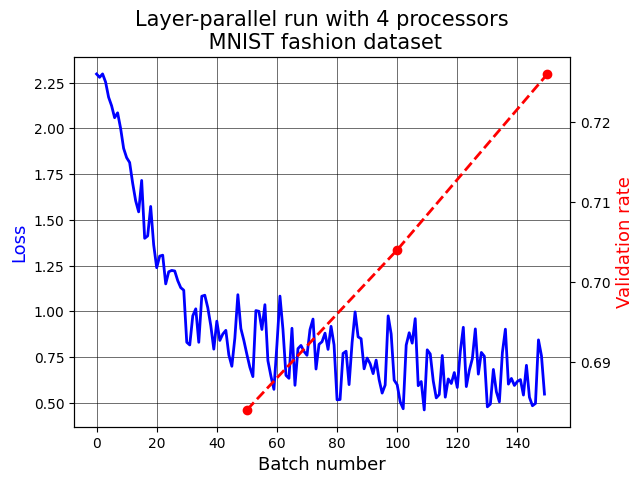

In [16]:
%%px
from matplotlib import pyplot as plt
%matplotlib inline

# plot the loss, validation 
root_print(rank, f'\nMin batch time:   {"{:.3f}".format(np.min(batch_times))} ')
root_print(rank, f'Mean batch time:  {"{:.3f}".format(stats.mean(batch_times))} ')


if rank == 0:
  fig, ax1 = plt.subplots()
  plt.title('Layer-parallel run with %d processors\n MNIST %s dataset'%(procs, params['dataset']), fontsize=15)
  ax1.plot(batch_losses, color='b', linewidth=2)
  ax1.grid(True, color='k', linestyle='-', linewidth=0.4)
  ax1.set_xlabel(r"Batch number", fontsize=13)
  ax1.set_ylabel(r"Loss", fontsize=13, color='b')
  
  ax2 = ax1.twinx()
  epoch_points = np.arange(1, len(validat_correct_counts)+1) * len(train_loader)
  validation_percentage = np.array(validat_correct_counts) / validat_size
  ax2.plot( epoch_points, validation_percentage, color='r', linestyle='dashed', linewidth=2, marker='o')
  ax2.set_ylabel(r"Validation rate", fontsize=13, color='r')


#### For comparison, we now repeat the above experiment, but with a sequential  Torchbraid network
- That is, the gradient evaluations will now be exact (rather than approxmiated by parallel-in-time XBraid).

In [17]:
%%px
# Repeat above experiment, but with a sequential TorchBraid network, i.e., do only 
# sequential network evaluation (i.e., one level in XBraid) 
params['lp_max_levels'] = 1

# Set seed for reproducibility
torch.manual_seed(params['seed'])

# Re-load data set, so that the data loader ordering will be the same 
if params['dataset'] == 'digits':
  root_print(rank, '-- Using Digit MNIST')
  transform = transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize((0.1307,), (0.3081,))
                                  ])
  dataset = datasets.MNIST(torchbraid_path + '/examples/mnist/digit-data', download=False, transform=transform)
else:
  root_print(rank, '-- Using Fashion MNIST')
  transform = transforms.Compose([transforms.ToTensor()])
  dataset = datasets.FashionMNIST(torchbraid_path + '/examples/mnist/fashion-data', download=False, transform=transform)

train_size = int(50000 * params['percent_data'])
test_size = int(10000 * params['percent_data'])
train_set = torch.utils.data.Subset(dataset, range(train_size))
test_set = torch.utils.data.Subset(dataset, range(train_size, train_size + test_size))
train_loader = torch.utils.data.DataLoader(train_set, batch_size=params['batch_size'], shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=params['batch_size'], shuffle=False)

[stdout:0] -- Using Fashion MNIST


In [18]:
%%px
# Create new network, but with sequential evaluation.  With max_levels==1, the 
# solver collapses to simple sequential evaluation
model = ParallelNet(channels=params['channels'],
                    local_steps=local_steps,
                    max_levels=params['lp_max_levels'],
                    bwd_max_iters=params['lp_bwd_max_iters'],
                    fwd_max_iters=params['lp_fwd_max_iters'],
                    print_level=params['lp_print_level'],
                    braid_print_level=params['lp_braid_print_level'],
                    cfactor=params['lp_cfactor'],
                    fine_fcf=params['lp_fine_fcf'],
                    skip_downcycle=not params['lp_use_downcycle'],
                    fmg=False, 
                    Tf=params['Tf'],
                    relax_only_cg=False,
                    user_mpi_buf=params['lp_user_mpi_buf'],
                    gpu_direct_commu=params['lp_gpu_direct_commu']).to(device)

In [19]:
%%px
# Declare optimizer
optimizer = optim.SGD(model.parameters(), lr=params['lr'], momentum=0.9)

# For better timings (especially with GPUs) do a little warm up
if params['warm_up']:
  warm_up_timer = timer()
  train(rank=rank, params=params, model=model, train_loader=train_loader, optimizer=optimizer, epoch=0,
        compose=model.compose, device=device)
  model.parallel_nn.timer_manager.resetTimers()
  model.parallel_nn.fwd_app.resetBraidTimer()
  model.parallel_nn.bwd_app.resetBraidTimer()
  if use_cuda:
    torch.cuda.synchronize()
  root_print(rank, f'\nWarm up timer {timer() - warm_up_timer}\n')

In [ ]:
%%px
# Carry out training
batch_losses = []; batch_times = []
epoch_times = []; test_times = []
validat_correct_counts = []

for epoch in range(1, params['epochs'] + 1):
  start_time = timer()
  [losses, train_times] = train(rank=rank, params=params, model=model, train_loader=train_loader, optimizer=optimizer, epoch=epoch,
        compose=model.compose, device=device)
  epoch_times += [timer() - start_time]
  batch_losses += losses
  batch_times += train_times

  start_time = timer()
  validat_correct, validat_size, validat_loss = test(rank=rank, model=model, test_loader=test_loader, compose=model.compose, device=device)
  test_times += [timer() - start_time]
  validat_correct_counts += [validat_correct]


root_print(rank,
           f'TIME PER EPOCH: {"{:.2f}".format(stats.mean(epoch_times))} '
           f'{("(1 std dev " + "{:.2f}".format(stats.mean(epoch_times))) if len(epoch_times) > 1 else ""}')
root_print(rank,
           f'TIME PER TEST:  {"{:.2f}".format(stats.mean(test_times))} '
           f'{("(1 std dev " + "{:.2f}".format(stats.mean(test_times))) if len(test_times) > 1 else ""}')

[stdout:0] Train Epoch: 1 [0/2500 (0%)]	Loss: 2.297403	Time Per Batch 0.362563
Train Epoch: 1 [500/2500 (20%)]	Loss: 1.838981	Time Per Batch 0.350687
Train Epoch: 1 [1000/2500 (40%)]	Loss: 1.241874	Time Per Batch 0.352099
Train Epoch: 1 [1500/2500 (60%)]	Loss: 0.831149	Time Per Batch 0.350542


%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

In [ ]:
%%px
from matplotlib import pyplot as plt
%matplotlib inline

# plot the loss, validation 
root_print(rank, f'\nMin batch time:   {"{:.3f}".format(np.min(batch_times))} ')
root_print(rank, f'Mean batch time:  {"{:.3f}".format(stats.mean(batch_times))} ')


if rank == 0:
  fig, ax1 = plt.subplots()
  plt.title('Layer-sequential run with %d processors\n MNIST %s dataset'%(procs, params['dataset']), fontsize=15)
  ax1.plot(batch_losses, color='b', linewidth=2)
  ax1.grid(True, color='k', linestyle='-', linewidth=0.4)
  ax1.set_xlabel(r"Batch number", fontsize=13)
  ax1.set_ylabel(r"Loss", fontsize=13, color='b')
  
  ax2 = ax1.twinx()
  epoch_points = np.arange(1, len(validat_correct_counts)+1) * len(train_loader)
  validation_percentage = np.array(validat_correct_counts) / validat_size
  ax2.plot( epoch_points, validation_percentage, color='r', linestyle='dashed', linewidth=2, marker='o')
  ax2.set_ylabel(r"Validation rate", fontsize=13, color='r')

#### For an M1 Macbook Pro, with 32GB RAM, we see about a 1.33x speedup with layer-parallel over the layer-sequential.
- Performance is *very* machine dependent, and software dependent.
- For truly large speedups, *parallel clusters are needed*, and the command line interface is recommended.